## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import sklearn
from sklearn.metrics import confusion_matrix 
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io, exposure, feature
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
import pickle
import cv2
plt.rcParams["figure.figsize"] = (20,3)

## Data PreProcessing Techniques

In [2]:
def face_detection(img):
    # Read image from your local file system
    original_image = img
    # Convert color image to grayscale for Viola-Jones
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    # Load the classifier and create a cascade object for face detection
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    for (column, row, width, height) in detected_faces:
        cv2.rectangle(
            original_image,
            (column, row),
            (column + width, row + height),
            (0, 255, 0),
            2
        )
        sub_face = img[row:row+height, column:column+width]
    return sub_face

#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
def smoothing(img, d=5, sigmaColor=65, sigmaSpace=65):
    blur_img = cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)
    return blur_img

#https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html
def histogram_equalization(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.equalizeHist(img)
    return dst


## Data Download, Preperation and Explorationa, PreProcessing

In [3]:
# get one image function and resize
def get_image(emotion_folders, emotion, img,is_filter=False, filters=None, log_it=False):
    input_img=cv2.imread(emotion_folders + '/'+ emotion + '/'+ img )
    if is_filter and filters == '1':
        input_img = smoothing(input_img)
    elif is_filter and filters == '2':
        input_img = face_detection(input_img)
    elif is_filter and filters == '3':
        input_img = histogram_equalization(input_img)
    input_img_resize=cv2.resize(input_img,(128,128))
    if log_it:
        print ('Loaded image for emotion: '+str(emotion))
    return input_img_resize

# get one image function and resize
def get_all_images(path, all_emotions_folders,is_filter=False, filters=None, log_it=False):
    emotions_list = os.listdir(path)
    indicies = []
    
    emos = []
    num_emos = []
    img_labels = []
    img_all_data=[]
    log_it=True
    for emotion in emotions_list:
        if emotion !='.DS_Store':
            img_list=os.listdir(path+'/'+ emotion) 
            emos.append(emotion)
            num_emos.append(len(img_list))
            print ('Loaded images for emotion: '+str(emotion)+', number of emotions: '+str(len(img_list)))
            for img in img_list:
                input_img_resize=get_image(path, emotion,img, is_filter, filters, log_it)
                if log_it:
                    indicies.append(len(img_all_data))
                img_all_data.append(input_img_resize)
                img_labels.append(emotion)
                log_it=False
            log_it=True
    img_data = np.array(img_all_data)
    img_labels = np.array(img_labels)
    # why to divide by 255 The reason is that if the color intensity is a float
    #, then matplotlib expects it to range from 0 to 1. If an int, 
    #then it expects 0 to 255. So you can either force all the numbers to int or scale them all by 1/255.
    #https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
    img_data = img_data.astype('float32')/255
    return img_data, img_labels, indicies
def standarize(data_list):
    mean, STD  = cv2.meanStdDev(data_list)
    data_list_standarize = (data_list - mean) / STD
    return data_list_standarize

One image Show
Loaded image for emotion: happy
(128, 128, 3)


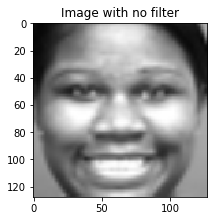

One image with face detection
Loaded image for emotion: happy
(128, 128, 3)


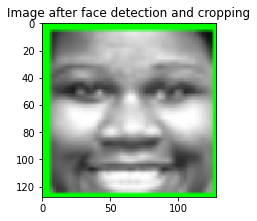

One image with smoothing
Loaded image for emotion: happy
(128, 128, 3)


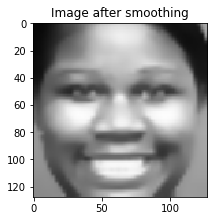

One image with histogram equalization
Loaded image for emotion: happy
(128, 128)


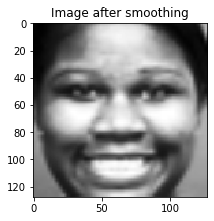

In [4]:
import os, cv2
path = './archive/CK+48'

all_emotions_folders = os.listdir(path)
if '.DS_Store' in all_emotions_folders: all_emotions_folders.remove('.DS_Store')

print("One image Show")
img_list=os.listdir(path+'/'+ all_emotions_folders[0])
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=False, filters=None, log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image with no filter') 
io.show()

print("One image with face detection")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='2', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after face detection and cropping') 
io.show()

print("One image with smoothing")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='1', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after smoothing') 
io.show()

print("One image with histogram equalization")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='3', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after smoothing') 
io.show()

In [5]:
img_data, img_labels, indicies = get_all_images(path, all_emotions_folders, is_filter=False, filters=None, log_it=True)
img_data_standarize = standarize(img_data)

Loaded images for emotion: happy, number of emotions: 207
Loaded image for emotion: happy
Loaded images for emotion: contempt, number of emotions: 54
Loaded image for emotion: contempt
Loaded images for emotion: fear, number of emotions: 75
Loaded image for emotion: fear
Loaded images for emotion: surprise, number of emotions: 249
Loaded image for emotion: surprise
Loaded images for emotion: sadness, number of emotions: 84
Loaded image for emotion: sadness
Loaded images for emotion: anger, number of emotions: 135
Loaded image for emotion: anger
Loaded images for emotion: disgust, number of emotions: 177
Loaded image for emotion: disgust


In [6]:
indicies

[0, 207, 261, 336, 585, 669, 804]

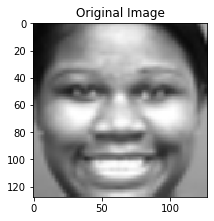

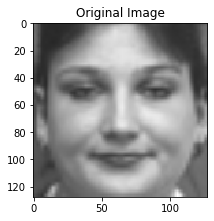

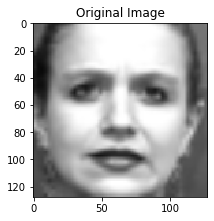

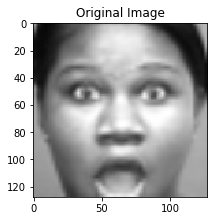

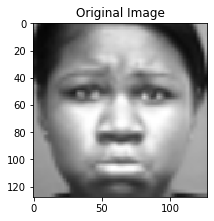

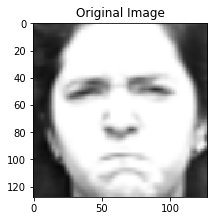

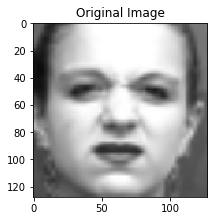

In [7]:
for i in indicies:
    io.imshow(img_data[i]) 
    plt.title('Original Image') 
    io.show()

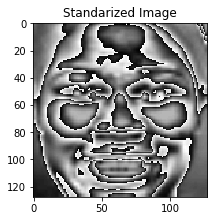

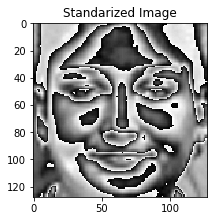

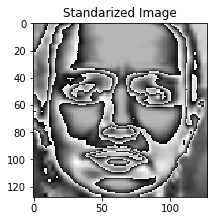

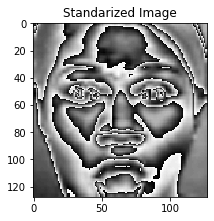

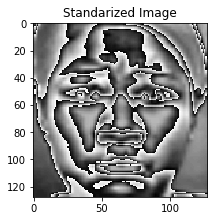

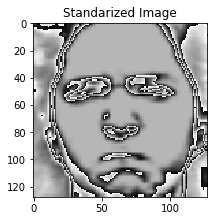

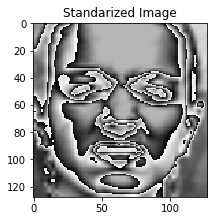

All images data Shape


(981, 128, 128, 3)

In [8]:
for i in indicies:
    io.imshow((img_data_standarize[i]* 255).astype(np.uint8)) 
    plt.title('Standarized Image') 
    io.show()
print("All images data Shape")
img_data_standarize.shape

Loaded images for emotion: happy, number of emotions: 207
Loaded image for emotion: happy
Loaded images for emotion: contempt, number of emotions: 54
Loaded image for emotion: contempt
Loaded images for emotion: fear, number of emotions: 75
Loaded image for emotion: fear
Loaded images for emotion: surprise, number of emotions: 249
Loaded image for emotion: surprise
Loaded images for emotion: sadness, number of emotions: 84
Loaded image for emotion: sadness
Loaded images for emotion: anger, number of emotions: 135
Loaded image for emotion: anger
Loaded images for emotion: disgust, number of emotions: 177
Loaded image for emotion: disgust


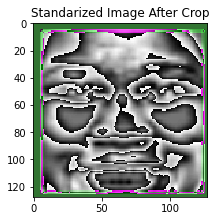

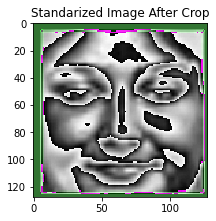

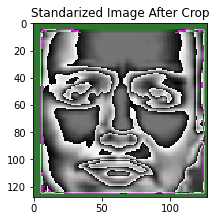

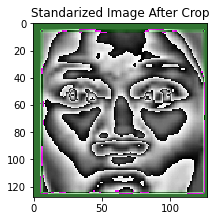

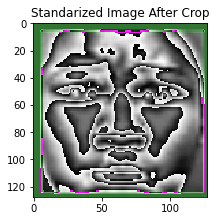

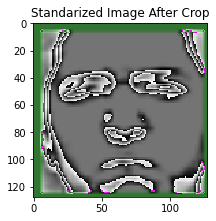

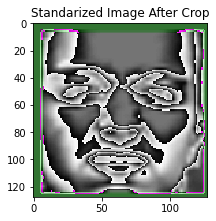

All images data Shape


(981, 128, 128, 3)

In [9]:
img_data_crop,img_labels, indicies = get_all_images(path, all_emotions_folders, is_filter=True, filters='2', log_it=True)
img_data_crop_standarize = standarize(img_data_crop)
for i in indicies:
    io.imshow((img_data_crop_standarize[i]* 255).astype(np.uint8)) 
    plt.title('Standarized Image After Crop') 
    io.show()
print("All images data Shape")
img_data_crop_standarize.shape

## Features Extraction

In [10]:
#num_points = 8 * radius
#https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def LBP_features(img, numPoints, radius):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f =feature.local_binary_pattern(gray, P=numPoints, R=radius, method="uniform")[:, :, None] 
    return f
def get_LBP_features(img_data):
    features = []
    for img in img_data:
        img_feature = LBP_features(img, 24, 3)
        features.append(img_feature)
    return np.array(features)
features_all = get_LBP_features(img_data)

/Users/fatimaalsaadeh/Desktop/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


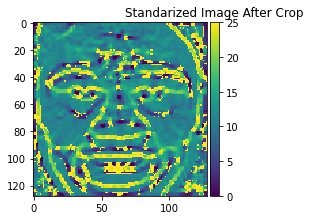

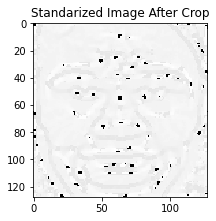

In [11]:
io.imshow(features_all[0]) 
plt.title('Standarized Image After Crop') 
io.show()
io.imshow((features_all[0]* 255).astype(np.uint8))
plt.title('Standarized Image After Crop') 
io.show()

## Model 1 : Smoothing + LBP + Standarization + CNN

#### Get Data, Apply Smoothing

In [95]:
smoothed_imgs, labels,indices = get_all_images(path, all_emotions_folders, is_filter=True, filters='1', log_it=True)

Loaded images for emotion: happy, number of emotions: 207
Loaded image for emotion: happy
Loaded images for emotion: contempt, number of emotions: 54
Loaded image for emotion: contempt
Loaded images for emotion: fear, number of emotions: 75
Loaded image for emotion: fear
Loaded images for emotion: surprise, number of emotions: 249
Loaded image for emotion: surprise
Loaded images for emotion: sadness, number of emotions: 84
Loaded image for emotion: sadness
Loaded images for emotion: anger, number of emotions: 135
Loaded image for emotion: anger
Loaded images for emotion: disgust, number of emotions: 177
Loaded image for emotion: disgust


### Get LBP Features

In [96]:
imgs_features = get_LBP_features(smoothed_imgs)
imgs_features.shape

(981, 128, 128, 1)

### Standarize Features

In [97]:
standarize_features = standarize(imgs_features)
standarize_features.shape

(981, 128, 128, 1)

### Data Splitting

In [128]:
import tensorflow.keras.utils as utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(set(labels_encoded))
labels_final = utils.to_categorical(labels_encoded, 7)
features_shuffled, labels_shuffled = sklearn.utils.shuffle(standarize_features, labels_final)

{0, 1, 2, 3, 4, 5, 6}


In [129]:
labels_final[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

(784, 128, 128, 1)
(197, 128, 128, 1)
[0. 0. 0. 0. 1. 0. 0.]


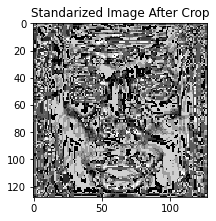

In [130]:
train_len = int(.8 * features_shuffled.shape[0])
all_len = int(len(features_shuffled))
train_ifeatures = features_shuffled[:train_len, :, :, :]
train_labels = labels_shuffled[:train_len]
test_ifeatures = features_shuffled[train_len:, :, :, :]
test_labels = labels_shuffled[:train_len]


print(train_ifeatures.shape)
print(test_ifeatures.shape)
print(test_labels[1])
io.imshow((test_ifeatures[0]* 255).astype(np.uint8))
plt.title('Standarized Image After Crop') 
io.show()

In [131]:
def create_model(optim):
    input_shape=(128,128,1)
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (5, 5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    
    return model

In [132]:
from keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten,  MaxPooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import cross_val_predict, cross_val_score

batch_size = 32 #batch size of 32 performs the best.
epochs = 100
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model = create_model(optimizer)
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 128)       204928    
_________________________________________________________________
activation_16 (Activation)   (None, 64, 64, 128)       0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 256)       819456    
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 14, 14, 256)     

In [133]:
early_stopping = EarlyStopping(

    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]
history = model.fit(x=train_ifeatures, y= train_labels, validation_split=0.1, batch_size=32, 
          epochs=25, shuffle=True, verbose=2 
         )

Train on 705 samples, validate on 79 samples
Epoch 1/25
705/705 - 69s - loss: 1.7328 - accuracy: 0.3716 - val_loss: 2.6232 - val_accuracy: 0.2911
Epoch 2/25
705/705 - 67s - loss: 1.6766 - accuracy: 0.4553 - val_loss: 1.9481 - val_accuracy: 0.2911
Epoch 3/25
705/705 - 66s - loss: 1.3602 - accuracy: 0.5589 - val_loss: 5.3735 - val_accuracy: 0.0633
Epoch 4/25
705/705 - 67s - loss: 1.4986 - accuracy: 0.5943 - val_loss: 2.3535 - val_accuracy: 0.2785
Epoch 5/25
705/705 - 67s - loss: 0.9434 - accuracy: 0.6936 - val_loss: 3.8300 - val_accuracy: 0.1139
Epoch 6/25
705/705 - 69s - loss: 0.8775 - accuracy: 0.7660 - val_loss: 0.4960 - val_accuracy: 0.8481
Epoch 7/25
705/705 - 69s - loss: 0.4316 - accuracy: 0.8723 - val_loss: 0.7338 - val_accuracy: 0.6582
Epoch 8/25
705/705 - 68s - loss: 0.3149 - accuracy: 0.8979 - val_loss: 0.3667 - val_accuracy: 0.8228
Epoch 9/25
705/705 - 68s - loss: 0.2185 - accuracy: 0.9461 - val_loss: 0.1728 - val_accuracy: 0.9494
Epoch 10/25
705/705 - 69s - loss: 0.1416 - acc

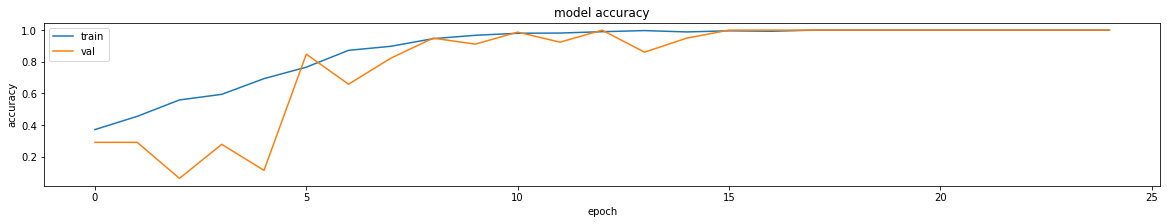

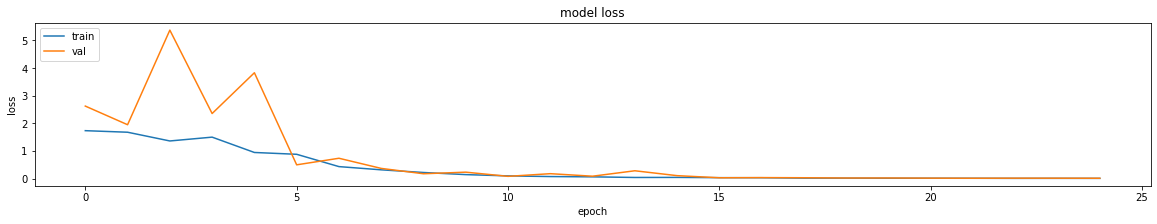

In [138]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [140]:
results = model.predict_classes(test_ifeatures)
err = 0
for i in range(len(results)): 
    l = np.argmax(test_labels[i], axis=-1)
    if results[i] !=l:
        err+=1
print("Accuracy: " + str(100*(1-(err/len(test_labels)))))

Accuracy: 79.71938775510205


## Model 2 

## Model 3

## Accuracy and Loss Comparisons

## Results